In [1]:
from get_bifurcations import get_bifurcations
from scipy.interpolate import UnivariateSpline
from numpy import *

from lib.colors import cyan,yellow
from matplotlib.pyplot import *
from numpy import *
from scipy.interpolate import interp2d
from json import loads,dumps

from os import system
from os.path import isfile
from re import finditer,sub,search

from re import sub,search,finditer,findall
from yaml import load

from lib.parser import fromcrn
from lib.roots import roots_parallel,roots

In [2]:
file_path = 'new.crn'
self = fromcrn(file_path)

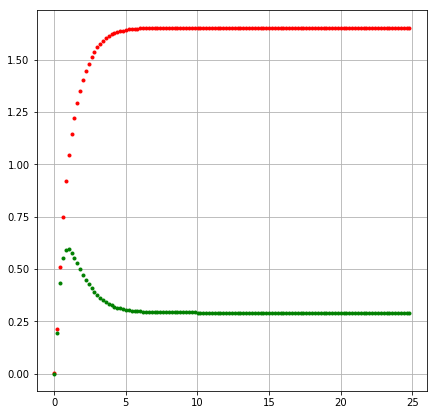

In [3]:
figure(figsize=(7,7))
for i in range(2500) :
    self.time_step()

    if i % 20 == 0 :
        plot(self.time,self.lacI[0],'r.')
        plot(self.time,self.tetR[0],'g.')
    
grid(True)

In [4]:
file_path = 'new.crn'
self = fromcrn(file_path)

N =150

c6_range = [-6,8]
c12_range = [-0.5,5]

c = logspace(*c6_range,num=N)
cdash = logspace(*c12_range,num=N)

# c6_range = [0,3]
# c12_range = [0,3]

# c = linspace(*c6_range,num=N)
# cdash = linspace(*c12_range,num=N)

c6,c12 = meshgrid(c,cdash,copy=False)
c_grid = dstack([c6,c12])

# calculation of steady states
steady_state = self.get_steady_state(c_grid,clip=clip)

In [5]:
T = steady_state[:,:,self.nontrivials.index('tetR')]
L = steady_state[:,:,self.nontrivials.index('lacI')]

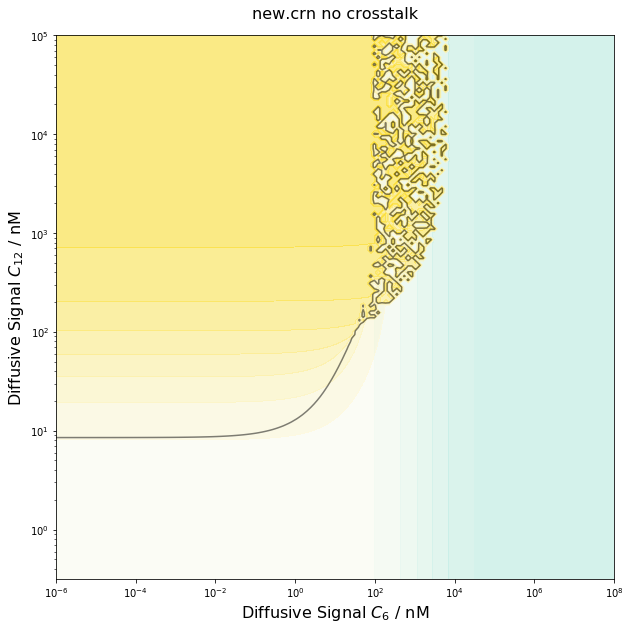

In [6]:
figure(figsize=(10,10))
title(file_path+' no crosstalk',fontsize=16,y=1.02)
contourf(c6,c12,
         L,
         cmap='cyan',alpha=0.5)
contourf(c6,c12,
         T,
         cmap='yellow',alpha=0.5)

contour(c6,c12,
         T-L,levels=[0.0],
         colors=['k'],alpha=0.5)

yscale('log')
xscale('log')

xlabel(r'Diffusive Signal $C_{6}$ / nM',fontsize=16)
ylabel(r'Diffusive Signal $C_{12}$ / nM',fontsize=16);

In [ ]:
auto.demo('bvp')
bvp = auto.run('bvp')
branchpoints = bvp("BP")
for solution in branchpoints:
    bp = auto.load(solution, ISW=-1, NTST=50)
    # Compute forwards
    print("Solution label", bp["LAB"], "forwards")
    fw = auto.run(bp)
    # Compute backwards
    print("Solution label", bp["LAB"], "backwards")
    bw = auto.run(bp,DS='-')
    both = fw + bw
    merged = auto.merge(both)
    bvp = bvp + merged

bvp=auto.relabel(bvp)
auto.save(bvp, 'bvp')
auto.plot(bvp)
auto.wait()

In [ ]:
def calculate(model,c6,c12,L,T):
    
    Lattractor = array([
        L[argmin(abs(c12[:,0]-c12x)),argmin(abs(c6[0]-c6x))]
        for c6x,c12x in model.state['diffusables'] ]).reshape(-1)

    Tattractor = array([
        T[argmin(abs(c12[:,0]-c12x)),argmin(abs(c6[0]-c6x))]
        for c6x,c12x in model.state['diffusables'] ]).reshape(-1)

    space = linspace(0,model.xmax,len(Lattractor))
    return space,Lattractor,Tattractor

def generate_frame(j,model,space,L,T):
    '''main program figure display'''

    figure(figsize=(10,10))

    # plot scaffolds
    plot(space,10**L,'.',color='darkcyan')
    plot(space,10**T,'.',color='gold')
    plot(-1,-1,'k.',label='Local Steady State')

    # plot system state
    plot(model.space,model.state['inhibitors'].T[0],color='darkcyan')
    plot(model.space,model.state['inhibitors'].T[1],color='gold')
    plot(-1,-1,'k',label='Concentration at $t = {}h$'.format(model.time[-1]))

    legend(fontsize=16)
    xlim(0,model.xmax)
    
    ylabel(r'Inhibitors $L(x,t),T(x,t)$ / nM',fontsize=16);
    xlabel(r'Space $x$ / cm',fontsize=16);
    yscale('log')

    savefig(str(j).zfill(4)+'.png')
    close()

    return j+1
    
def create_animation(C6,C12):
    '''execute system commands to create animation from frames'''
    system('convert -delay 10 -loop 0 *.png c6-{}_c12-{}.gif'.format(C6,C12))
    system('rm *.png')

In [ ]:
C6=120;C12=40
t_final = 750.0
p = 0.01

# import model from file
model = fromcrn(crn_path)
model.dt = 0.25

# initial condition
model.state['diffusables'][:,0][model.space<p] = model.xmax * C6 / p
model.state['diffusables'][:,1][model.space>(model.xmax-p)] = model.xmax * C12 / p

# create bifrucation figure
i,j = 0,0
while model.time[-1] < t_final :

    model.time_step()
    space,Lattractor,Tattractor = calculate(model,c6,c12,L,T)
    
    if i % 10 == 0 :
        j = generate_frame(j,model,space,Lattractor,Tattractor)
    i += 1

create_animation(C6,C12)

In [ ]:
model.time[-1]

In [ ]:
import os
import sys
auto_directory = os.system("echo $AUTO_DIR")
print auto_directory
#auto_directory = !echo $AUTO_DIR
if auto_directory == ['']:
    home = os.system("echo $HOME")
    auto_directory = home[0]+'/auto/07p/'
    sys.path.append(auto_directory+'/python')
else:
    sys.path.append(auto_directory[0] + '/python')
    


import AUTOCommands as ac
import AUTOclui as acl
import interactiveBindings as ib
import runAUTO as ra